In [1]:
# MORE -> https://github.com/boyander/datamad-1019/blob/master/w7-d5-spark-intro/spark-intro.ipynb

# After running this cell, check http://localhost:4040 (spark dashboard)
# and you will see apache spark running.
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()

In [5]:
import random
num_samples = 1000000

# This function will be parallelized using spark
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1


count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

3.143292


In [17]:
# SPARK RDD

# Loading a CSV
csvreader = spark.read.format("csv").option("header", "true")
df = csvreader.load("data/breadbasket_dms.csv")
df.registerTempTable("breadbasket")
print(type(df))
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+----------+--------+-----------+-------------+
|      Date|    Time|Transaction|         Item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:07:57|          3|Hot chocolate|
|2016-10-30|10:07:57|          3|          Jam|
|2016-10-30|10:07:57|          3|      Cookies|
|2016-10-30|10:08:41|          4|       Muffin|
|2016-10-30|10:13:03|          5|       Coffee|
|2016-10-30|10:13:03|          5|       Pastry|
|2016-10-30|10:13:03|          5|        Bread|
|2016-10-30|10:16:55|          6|    Medialuna|
|2016-10-30|10:16:55|          6|       Pastry|
|2016-10-30|10:16:55|          6|       Muffin|
|2016-10-30|10:19:12|          7|    Medialuna|
|2016-10-30|10:19:12|          7|       Pastry|
|2016-10-30|10:19:12|          7|       Coffee|
|2016-10-30|10:19:12|          7|          Tea

In [19]:
spark.sql("show tables").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|        |breadbasket|       true|
+--------+-----------+-----------+



In [38]:
# EX1: GROUP ITEMS BY TICKET WITH SQL SYNTAX

df2 = spark.sql("""
SELECT 
        Transaction as ticket_id,
        CONCAT(max(Date)," ",max(Time)) as ticket_date,
        count(Item) as ticket_items,
        collect_list(Item) as items,
        approx_count_distinct(Item) as ticket_numitems
    FROM breadbasket GROUP BY Transaction
""")
df2.show()

+---------+-------------------+------------+--------------------+
|ticket_id|        ticket_date|ticket_items|               items|
+---------+-------------------+------------+--------------------+
|     1090|2016-11-11 16:20:18|           5|[Brownie, Coffee,...|
|     1159|2016-11-12 13:19:37|           1|             [Bread]|
|     1436|2016-11-16 12:19:46|           2|      [Coffee, Soup]|
|     1512|2016-11-17 12:49:02|           3|[Hearty & Seasona...|
|     1572|2016-11-18 10:49:51|           2|    [Pastry, Coffee]|
|     2069|2016-11-26 08:29:14|           1|             [Bread]|
|     2088|2016-11-26 10:30:16|           1|      [Scandinavian]|
|     2136|2016-11-26 14:09:08|           2|[Hot chocolate, Tea]|
|     2162|2016-11-27 10:03:29|           8|[Coffee, Tea, Jui...|
|     2294|2016-11-29 12:21:00|           2|         [Tea, NONE]|
|     2904|2016-12-10 10:14:55|           4|[NONE, Sandwich, ...|
|      296|2016-11-02 11:58:42|           2|[Farm House, Scan...|
|     3210

In [33]:
# EX1: SAME GROUPING EXAMPLE BUT WITH SPARK SYNTAX
from pyspark.sql.functions import collect_list, approx_count_distinct

q = df.groupby(df.Transaction).agg(collect_list("Item"), approx_count_distinct("Item"))
print(q.show())
print(q.head())

+-----------+--------------------+---------------------------+
|Transaction|  collect_list(Item)|approx_count_distinct(Item)|
+-----------+--------------------+---------------------------+
|       1090|[Brownie, Coffee,...|                          4|
|       1159|             [Bread]|                          1|
|       1436|      [Coffee, Soup]|                          2|
|       1512|[Hearty & Seasona...|                          3|
|       1572|    [Pastry, Coffee]|                          2|
|       2069|             [Bread]|                          1|
|       2088|      [Scandinavian]|                          1|
|       2136|[Hot chocolate, Tea]|                          2|
|       2162|[Coffee, Tea, Jui...|                          7|
|       2294|         [Tea, NONE]|                          2|
|       2904|[NONE, Sandwich, ...|                          4|
|        296|[Farm House, Scan...|                          2|
|       3210|      [Bread, Bread]|                     

In [53]:
from pyspark.sql.functions import explode
from pyspark.sql import functions as F

#df.groupBy("ticket_id").pivot("items").agg(F.lit(1)).na.fill(0).show()
m = df2.withColumn("item", explode(df2.items))
m.show()


+---------+-------------------+------------+--------------------+-----------------+
|ticket_id|        ticket_date|ticket_items|               items|             item|
+---------+-------------------+------------+--------------------+-----------------+
|     1090|2016-11-11 16:20:18|           5|[Brownie, Coffee,...|          Brownie|
|     1090|2016-11-11 16:20:18|           5|[Brownie, Coffee,...|           Coffee|
|     1090|2016-11-11 16:20:18|           5|[Brownie, Coffee,...|    Hot chocolate|
|     1090|2016-11-11 16:20:18|           5|[Brownie, Coffee,...|           Coffee|
|     1090|2016-11-11 16:20:18|           5|[Brownie, Coffee,...|            Juice|
|     1159|2016-11-12 13:19:37|           1|             [Bread]|            Bread|
|     1436|2016-11-16 12:19:46|           2|      [Coffee, Soup]|           Coffee|
|     1436|2016-11-16 12:19:46|           2|      [Coffee, Soup]|             Soup|
|     1512|2016-11-17 12:49:02|           3|[Hearty & Seasona...|Hearty & Se

In [69]:
s = m.groupBy("ticket_id").pivot("item").count().na.fill(0)
print(s.columns,len(s.columns))
s.select(s.columns[:7]).show()

['ticket_id', 'Adjustment', 'Afternoon with the baker', 'Alfajores', 'Argentina Night', 'Art Tray', 'Bacon', 'Baguette', 'Bakewell', 'Bare Popcorn', 'Basket', 'Bowl Nic Pitt', 'Bread', 'Bread Pudding', 'Brioche and salami', 'Brownie', 'Cake', 'Caramel bites', 'Cherry me Dried fruit', 'Chicken Stew', 'Chicken sand', 'Chimichurri Oil', 'Chocolates', 'Christmas common', 'Coffee', 'Coffee granules ', 'Coke', 'Cookies', 'Crepes', 'Crisps', 'Drinking chocolate spoons ', 'Duck egg', 'Dulce de Leche', 'Eggs', "Ella's Kitchen Pouches", 'Empanadas', 'Extra Salami or Feta', 'Fairy Doors', 'Farm House', 'Focaccia', 'Frittata', 'Fudge', 'Gift voucher', 'Gingerbread syrup', 'Granola', 'Hack the stack', 'Half slice Monster ', 'Hearty & Seasonal', 'Honey', 'Hot chocolate', 'Jam', 'Jammie Dodgers', 'Juice', 'Keeping It Local', 'Kids biscuit', 'Lemon and coconut', 'Medialuna', 'Mighty Protein', 'Mineral water', 'Mortimer', 'Muesli', 'Muffin', 'My-5 Fruit Shoot', 'NONE', 'Nomad bag', 'Olum & polenta', 'P

In [70]:
s.filter("ticket_id=1090").select("Coffee").show()

+------+
|Coffee|
+------+
|     2|
+------+



In [75]:
s.count()

9531

In [78]:
def suma(a:int,b:int):
    return a+b

In [80]:
suma("5","4")

'54'

In [85]:
import pandas as pd

q = s.toPandas()

In [90]:
q.drop(columns=["ticket_id"],inplace=True)
q.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fv = pca.fit_transform(q)

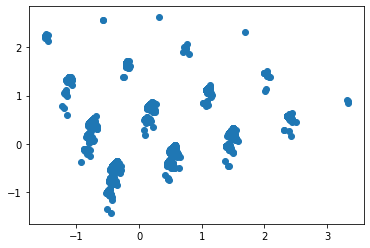

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(fv[:,0],fv[:,1])